In [73]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys


import re

from sklearn.cluster import DBSCAN


from nn_generalizability.nets import Nets
from nn_generalizability.utils import *
from nn_generalizability.postprocessing.postprocessing import *
from nn_generalizability.postprocessing.stats_plotting import *
from nn_generalizability.postprocessing.GA import *
from nn_generalizability.save_load import *

from nn_generalizability.postprocessing.sharpness_measures import *
from nn_generalizability.postprocessing.stats_plotting import *
from nn_generalizability.postprocessing.interpolation import *

from nn_generalizability.data_getters import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
root_folder = os.environ["PATH_TO_GEN_FOLDER"]
data_name = "CIFAR10"
exp = "SimpleNet_high_steps"
experiment_folder = os.path.join(root_folder, "experiments", data_name, exp)

In [26]:
# get all sorts of data
exp_dict = {}

def get_stuff(experiment_folder):
    stuff = {}

    stuff_to_try = ["tsne", "runs", "trace", "acc", "dist", "loss", "grad", "eig"]

    for singular_stuff in stuff_to_try:
        print("Getting {}.".format(singular_stuff))
        data, meta = load_cached_data(experiment_folder, singular_stuff)
        if data is None:
            print("Error: {} could not be found".format(singular_stuff))
        else:
            stuff[singular_stuff] = data
    
    stuff["configs"] = load_configs(experiment_folder)
    
    return stuff

exp_dict["stuff"] = get_stuff(experiment_folder)
exp_dict["models"] = get_all_models(experiment_folder, -1)
exp_dict["resampling_idxs"] = get_sample_idxs(experiment_folder)

Getting tsne.
Error: tsne could not be found
Getting runs.
Getting trace.
Getting acc.
Getting dist.
Error: dist could not be found
Getting loss.
Getting grad.
Error: grad could not be found
Getting eig.
Error: eig could not be found


In [4]:
stats_df = get_end_stats(exp_dict)


Error: No stats for 1594678537.6570415
YO
Error: No stats for 1594673313.8724134
YO
Error: No stats for 1594672291.0710459
YO


In [5]:
# stats_df = stats_df[stats_df["Acc Test Mean"] > 0.15]
stats_df.sort_values(by="Acc Test Max", ascending=False)

,Acc Test Max,Acc Test Mean,Acc Test Min,Acc Train Max,Acc Train Mean,Acc Train Min,Gap Mean,Loss Test Max,Loss Test Mean,Loss Test Min,...,Loss Train Mean,Loss Train Min,Norm Max,Norm Mean,Norm Min,Trace Max,Trace Mean,Trace Mean Std,Trace Min,batch_train_size
1594673313.8724134,0.5218,0.52050,0.5192,1.00000,1.00000,1.00,-0.47950,6.284950,6.268951,6.252953,...,0.000034,0.000034,35.086926,35.047825,35.008724,5.102764,5.073478,0.422046,5.044191,256
1594678537.6570415,0.5125,0.51240,0.5123,1.00000,1.00000,1.00,-0.48760,6.762398,6.747038,6.731678,...,0.000044,0.000043,30.368324,30.281442,30.194559,16.183148,15.898602,0.903751,15.614057,4096
1594672291.0710459,0.5051,0.49945,0.4938,0.95368,0.95184,0.95,-0.45239,3.561881,3.524724,3.487566,...,0.147665,0.141272,87.128716,86.997990,86.867264,339.959930,331.146362,7.278381,322.332794,32


# Get data

In [6]:
# get data
seed = 0
num_datapoints = 100
on_test_set = False

train_data, test_data = get_data_from_experiment(experiment_folder)
if on_test_set:
    data = get_random_data_subset(test_data, num_datapoints=num_datapoints, seed=seed)
else:
    data = get_random_data_subset(train_data, num_datapoints=num_datapoints, seed=seed)

criterion = torch.nn.CrossEntropyLoss()



Files already downloaded and verified
Files already downloaded and verified


# Model output scaling

In [7]:
m = exp_dict["models"]["1594672291.0710459"]["0"]

In [69]:
data

[tensor([[ 0.6314,  0.6157,  0.6235,  ..., -0.7647, -0.8118, -0.7725],
         [-0.3882, -0.1765,  0.0667,  ...,  0.2392,  0.2549,  0.2471],
         [-0.2314, -0.3255, -0.3333,  ...,  0.6314,  0.6471,  0.6471],
         ...,
         [-0.2784, -0.3020, -0.3412,  ...,  0.0980,  0.0902,  0.0902],
         [ 0.5922,  0.6235,  0.6627,  ...,  0.5294,  0.5529,  0.5373],
         [ 0.6941,  0.5765,  0.6471,  ..., -0.8431, -0.7725, -0.8667]]),
 tensor([4, 9, 9, 5, 8, 9, 7, 5, 3, 5, 6, 5, 8, 7, 1, 8, 5, 0, 7, 2, 8, 5, 4, 9,
         6, 6, 8, 4, 6, 2, 5, 9, 6, 1, 5, 8, 4, 1, 2, 9, 0, 0, 5, 2, 5, 5, 3, 6,
         7, 7, 2, 3, 1, 3, 1, 6, 7, 2, 5, 9, 3, 2, 4, 9, 3, 3, 3, 6, 1, 8, 1, 5,
         3, 0, 9, 3, 9, 3, 3, 1, 8, 5, 0, 1, 5, 3, 6, 2, 7, 8, 6, 5, 5, 2, 3, 9,
         1, 2, 8, 2])]

In [36]:
model_outputs = get_model_outputs(m, data, softmax_outputs=False, device=None)
_, predicted = torch.max(model_outputs, 1)
correct_filter = (predicted == data[1]).detach().numpy()
first_incorrect_idx = np.arange(0, len(data[0]))[~correct_filter][0]




In [64]:
data[1][11] = 7

max_alpha = 9

scale_arr = []


for alpha in np.linspace(0, max_alpha, 2): 
    scale_arr.append(scale_output_model(m, alpha))
    
model_dict = {str(i): scale_arr[i] for i in range(len(scale_arr))}

In [61]:
get_point_traces(model_dict, [[data[0][first_incorrect_idx]], [data[1][first_incorrect_idx]]])# [data[1][first_incorrect_idx]]])
# loss_dict, acc_dict = get_models_loss_acc(model_dict, full_train_loader, test_loader)

{'0': [133.23150634765625], '1': [-2147.7110595703125]}

In [82]:
eigs = get_point_eig_density(model_dict, [[data[0][first_incorrect_idx]], [data[1][first_incorrect_idx]]])# [data[1][first_incorrect_idx]]])
eigs["0"][0]

([[153.42253,
   -137.5569,
   -120.007515,
   -107.93776,
   -102.50538,
   -91.39254,
   -88.58853,
   1.368904e-05,
   -71.66885,
   -63.719173,
   -54.71403,
   -43.429867,
   -47.617702,
   -18.73401,
   124.34333,
   42.590477,
   44.789024,
   51.19614,
   61.29596,
   102.77475,
   100.36966,
   97.17401,
   71.42085,
   85.29749,
   79.42174]],
 [[8.9402533e-07,
   2.327499e-06,
   6.625031e-07,
   4.1842793e-07,
   1.03428455e-07,
   1.8177042e-06,
   5.357678e-07,
   0.9998934,
   2.28654e-06,
   4.810786e-06,
   1.47516275e-05,
   1.7557171e-05,
   6.5830895e-06,
   2.668905e-10,
   4.3996786e-07,
   1.2755495e-05,
   2.4390434e-05,
   7.5727953e-06,
   2.0061325e-06,
   1.5542404e-06,
   5.5037976e-08,
   5.670602e-07,
   1.1890304e-06,
   2.7326384e-06,
   5.5301217e-07]])

In [81]:
np.array(x[0]).dot(np.array(y[0]))

-0.0014416869

In [83]:
np.array(x[0]).dot(np.array(y[0]))

-0.0014416869

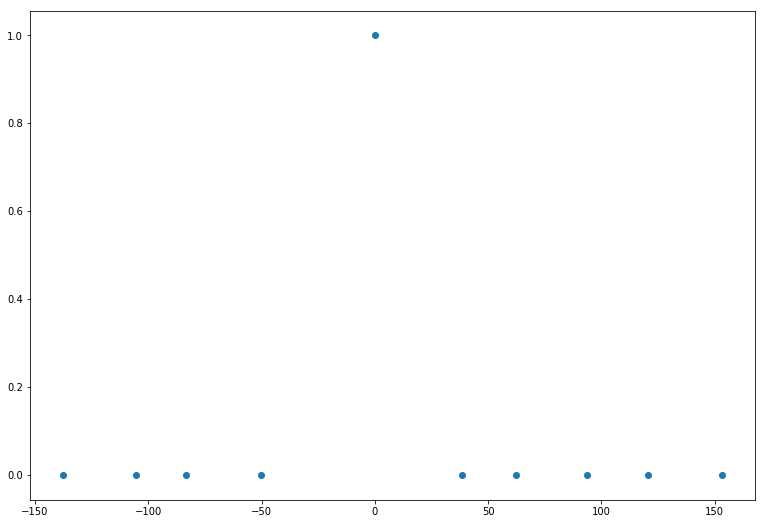

In [79]:
x, y = eigs["0"][0]
plt.scatter(x, y)

In [146]:
model_a = exp_dict["models"]["1593847785.5662594"][str(2)]
model_a = exp_dict["models"]["1593841465.3004317"][str(0)]
# model_b = exp_dict["models"]["1592850561.9180126"][str(1)]
# model_c = exp_dict["models"]["1592850561.9180126"][str(2)]


# Interpolate two models

In [108]:
# model_a = vec_to_net(v1_vec, model_c)
# model_b = vec_to_net(v2_vec, model_c)

beta_bound = [0, 20]
num_inter_models = 2

inter_arr = get_model_interpolate_arr(model_a, model_b, num_inter_models, beta_bound=beta_bound)

model_dict = {str(i): inter_arr[i] for i in range(len(inter_arr))}





In [148]:
eigenvals = get_models_eig(model_dict, train_loader, None, criterion, num_eigenthings=1)

0
1
2
3
4
5
6
7
8
9


In [143]:
traces = get_models_trace(model_dict, full_train_loader, criterion, full_dataset=False)
loss_dict, acc_dict = get_models_loss_acc(model_dict, full_train_loader, test_loader)

In [149]:
a = time.time()
traces_batch = get_models_trace(model_dict, train_loader, criterion, full_dataset=False)
loss_dict_batch, acc_dict_batch = get_models_loss_acc(model_dict, train_loader, test_loader)
print(time.time() - a)

59.97638201713562


In [151]:
loss_dict_batch

{'0': (2.3026678562164307, 2.3025851249694824),
 '1': (0.24088889360427856, 0.24736303091049194),
 '2': (0.08198236674070358, 0.034661777317523956),
 '3': (0.06260377913713455, 0.005912907887250185),
 '4': (0.0636124312877655, 0.0010521834483370185),
 '5': (0.06993412226438522, 0.00018892886873800308),
 '6': (0.07826332002878189, 3.397406908334233e-05),
 '7': (0.08755455911159515, 6.079655122448457e-06),
 '8': (0.09738297015428543, 1.0728830375228426e-06),
 '9': (0.1075439602136612, 2.3841855067985307e-07)}

In [130]:
[np.mean(traces[t]) for t in traces]

[372.0205357869466, 0.0058747010105954746, 1.1182875748648836e-07]

In [111]:
eigenvals

{'0': array([35.490803], dtype=float32),
 '1': array([441948.06], dtype=float32)}

In [95]:
dim = 5 
nums = 20
prob = 0.1
ys = np.random.uniform(high=dim, size=nums).astype("int")
w = []
for i in range(nums):
    t = np.random.rand(dim)
    eps = np.random.uniform()
    if eps < prob:
        idx = np.random.uniform(high=dim, size=1).astype("int")
        t[idx] = max(t) * 2
    else:
        t[ys[i]] = max(t) * 2
    
    w.append(t)



In [96]:
def cross_entropy(w, y):
    return - np.log(w[y]) # - np.sum(np.array([y[i] * np.log(w[i]) for i in range(len(w))]))

def softmax_beta(w, beta):
    denom = 0
    for i in range(len(w)):
        denom = denom + np.exp(beta * w[i])
    return np.array([np.exp(beta * w[i])/denom for i in range(len(w))])


In [97]:
res = []
for a in np.linspace(0, 10, 100):

    L = 0
    for i in range(nums):
        s = softmax_beta(w[i], a)
        l = cross_entropy(s, ys[i])
        L += l
    res.append(L)



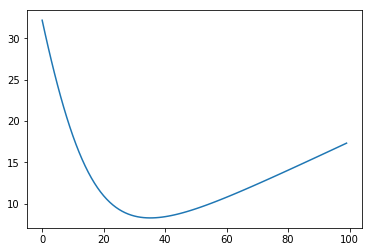

In [98]:
plt.plot(res)

ValueError: x and y must have same first dimension, but have shapes (3,) and (4,)

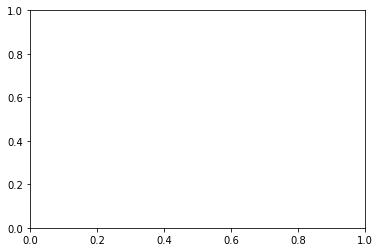

In [131]:

xs = np.linspace(beta_bound[0], beta_bound[1], num_inter_models)
loss_arr = [loss_dict_batch[a][0] for a in loss_dict_batch]
acc_arr = [acc_dict_batch[a][1] for a in acc_dict_batch]

plt.plot(xs, loss_arr)
# plt.plot(xs, acc_arr)
plt.ylim([0, 1])


(0, 1)

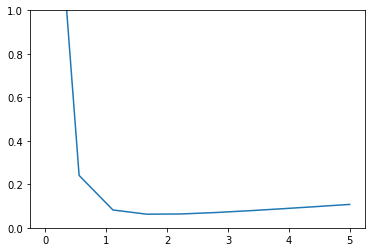

In [156]:

xs =  np.linspace(0, max_alpha, num_inter_models)
loss_arr = [loss_dict_batch[a][0] for a in loss_dict_batch]
acc_arr = [acc_dict_batch[a][1] for a in acc_dict_batch]

plt.plot(xs, loss_arr)
# plt.plot(xs, acc_arr)
plt.ylim([0, 1])


0


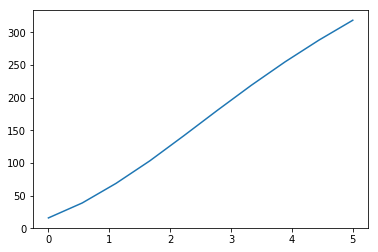

In [157]:

xs = np.linspace(0, max_alpha, num_inter_models)
ys = [np.mean(traces_batch[a]) for a in traces_batch]
ys_eigs = [eigenvals[i] for i in eigenvals]
print(np.argmin(ys))
# plt.plot(xs, ys)
plt.plot(xs, ys_eigs)
# plt.ylim([0, 10000])


# 2D

In [54]:
def create_offset_basis(offset, model1, model2):
    v1_vec = get_params_vec(model1) - get_params_vec(offset)
    w2_vec = get_params_vec(model2) - get_params_vec(offset)
    proj_w2 = torch.matmul(v1_vec, w2_vec) * v1_vec / torch.norm(v1_vec) ** 2
    assert torch.norm(proj_w2) != torch.norm(w2_vec) # make sure not lin dep
    v2_vec = w2_vec - proj_w2
    return offset, v1_vec, w2_vec

In [55]:
num_inter_models = 11
alpha_bound = [-3, 3]
beta_bound = [-3, 3]
func = lambda x: get_net_loss(x, full_train_loader, full_dataset=False)
# func = lambda net: np.mean(list(get_models_trace({"net": net}, d_t, criterion, full_dataset=False).values())[0])

X = np.linspace(alpha_bound[0], alpha_bound[1], num_inter_models)
Y = np.linspace(beta_bound[0], beta_bound[1], num_inter_models)

offset, v1_vec, v2_vec = create_offset_basis(model_a, model_b, model_c)

vals = get_model_interpolate_2d(offset, v1_vec, v2_vec, num_inter_models, alpha_bound, beta_bound, func)



In [56]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=vals, x=X, y=Y, colorscale="Viridis")])

# fig.update_layout(title='Function', autosize=False,
#                   width=1000, height=800,
#                   margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [507]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=vals, x=X, y=Y, colorscale="Viridis")])

# fig.update_layout(title='Function', autosize=False,
#                   width=1000, height=800,
#                   margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [232]:

exp_id = "1590496353.8190389" # sharp
# exp_id = "1590496353.106369" # flat

exp_id = "1590274168.6045089"

model_a = exp_dict["models"][exp_id][str(0)]
net = copy.deepcopy(model_a)


In [410]:
d_t = []
for i, (data, target) in enumerate(train_loader):
    d_t.append((data, target))
    
    break

In [36]:

beta_bound = [-3,3]
num_inter_models = 20

inter_a = get_model_interpolate_arr(model_c, model_d, num_inter_models, beta_bound=beta_bound)

In [37]:
model_dict = {str(i): inter_a[i] for i in range(len(inter_a))}

In [38]:
traces = get_models_trace(model_dict, full_train_loader, criterion, full_dataset=False)
loss_dict,acc_dict = get_models_loss_acc(model_dict, full_train_loader, test_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [365]:
def get_gap(b):
    a = list(b.values())[0]
    return a[1] - a[0]

In [94]:
print("Trace flat: {}".format(np.mean(list(trace.values())[0])))

print("Acc flat: {}".format(get_gap(acc_dict)))
print("Loss flat: {}".format(get_gap(loss_dict)))

Trace flat: 2.773572015762329
Acc flat: -0.055400000000000005
Loss flat: 0.23567577661015093


19


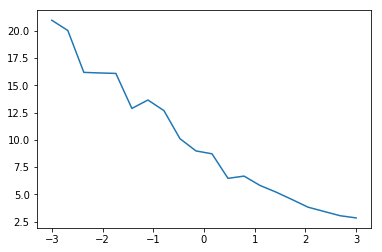

In [39]:

xs = np.linspace(beta_bound[0], beta_bound[1], num_inter_models)
ys = [np.mean(traces[a]) for a in traces]
print(np.argmin(ys))
plt.plot(xs, ys)

19


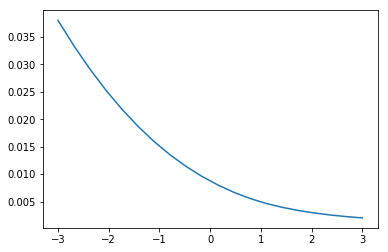

In [40]:

xs = np.linspace(beta_bound[0], beta_bound[1], num_inter_models)
ys = [loss_dict[a][0] for a in loss_dict]
print(np.argmin(ys))
plt.plot(xs, ys)

19


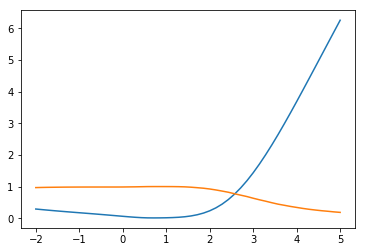

In [207]:

xs = np.linspace(beta_bound[0], beta_bound[1], 50)
loss_arr = [loss_dict[a][0] for a in loss_dict]
acc_arr = [acc_dict[a][0] for a in acc_dict]
trace_arr = [np.mean(traces[a]) for a in traces]

print(np.argmin(ys))
plt.plot(xs, loss_arr)
plt.plot(xs, acc_arr)
# plt.plot(xs, trace_arr)

16


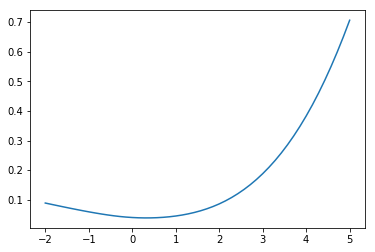

In [150]:
xs = np.linspace(beta_bound[0], beta_bound[1], num_inter_models)
ys = [float(a[0]) for a in i_a[1]]
print(np.argmin(ys))

plt.plot(xs, ys)

In [ ]:
def project_onto(net, v1, v2):
    v1_norm = v1/torch.norm(v1)
    v2_norm = v2/torch.norm(v2)
    
    net_vect = get_params_vec(net)
    alpha = torch.matmul(v1_norm, net_vect)
    beta = torch.matmul(v2_norm, net_vec)
    
    return alpha, beta

In [195]:
np.e**250 - np.e**240

3.7462845257262665e+108

In [196]:
x=  np.random.normal(scale=1, size=(1000, 2))
y = 1 * (x[:, 0] >= 0)
ct = 0
def flip(val, alpha):
    should_flip = np.random.uniform(0, 1)<alpha
    global ct
    if should_flip:
        ct += 1
        if val == 0:
            val = 1
        elif val == 1:
            val = 0
    return val
y = [flip(a, 0.05) for a in y]
x += np.random.normal(scale=0.15, size=x.shape)

In [197]:
c = 0
for a, b in zip(x, y):
    if (a[0] < 0) and (b == 1):
        c+=1
    elif (a[0] > 0) and (b == 0):
        c+=1 

In [90]:
def get_max(n, mu, cov):
    Xs = np.random.multivariate_normal(mu, cov, n)
    Xs_sq = [np.linalg.norm(x)**2 for x in Xs]
    return np.linalg.norm(Xs[np.argmax(Xs_sq)])

def get_mean(mu, cov, num_rv_samples, N):
    Rs = []
    for _ in range(num_rv_samples):
        Rs.append(get_max(N, mu, cov))
        
    return np.mean(Rs)

In [92]:
from scipy.stats import ortho_group  # Requires version 0.18 of scipy



In [93]:
N = 20
res = []
dim = 5

mu = np.zeros(dim)




for _ in range(0, 1000, 1):
    eigs = np.random.uniform(0, 100, dim)
    d_eigs = np.diag(eigs)
    P = ortho_group.rvs(dim=dim)

    cov = P.T.dot(d_eigs.dot(P))
    a =  np.sqrt(eigs.dot(eigs))
    res.append((a, get_mean(mu, cov, 100, N)))
res = np.array(res)

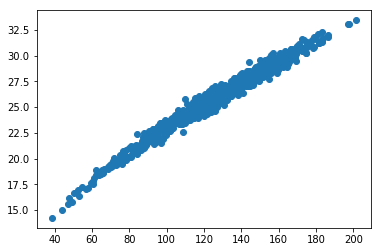

In [94]:
plt.scatter(res[:, 0], res[:, 1])

In [55]:
N = 20
res = []
mu = np.array([0, 0])
for a in range(1000):
    res.append((a, 5*((a**2 + 1**2 + 500**2))**0.5))
res = np.array(res)

In [239]:
u, s, vh = np.linalg.svd(np.array([a.detach().numpy() for a in grad_arr]), full_matrices=False)

In [235]:
# get data
train_data, test_data = get_postprocessing_data(experiment_folder, vectorized=True)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)  # fix the batch size
full_train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)  # fix the batch size

test_loader = DataLoader(test_data, batch_size=1 ) #len(test_data))

criterion = torch.nn.CrossEntropyLoss()
cfs_dict = exp_dict["stuff"]["configs"].loc[exp_id].to_dict()
optimizer = optim.SGD(net.parameters(), lr=cfs_dict["learning_rate"],
                                    momentum=cfs_dict["momentum"])
num_steps = 1000

data = next(iter(full_train_loader))

model_b, grad_arr, projs = take_n_gd_steps(net, optimizer, criterion, data, n=num_steps, get_grad=False,
                                           v1=None, v2=None, offset=model_a)



0
tensor(0.0088, grad_fn=<NllLossBackward>)

100
tensor(0.0081, grad_fn=<NllLossBackward>)

200
tensor(0.0076, grad_fn=<NllLossBackward>)

300
tensor(0.0071, grad_fn=<NllLossBackward>)

400
tensor(0.0067, grad_fn=<NllLossBackward>)

500
tensor(0.0063, grad_fn=<NllLossBackward>)

600
tensor(0.0060, grad_fn=<NllLossBackward>)

700
tensor(0.0057, grad_fn=<NllLossBackward>)

800
tensor(0.0054, grad_fn=<NllLossBackward>)

900
tensor(0.0052, grad_fn=<NllLossBackward>)

